## Corpus Validation Analysis
#### David da Costa Correia @ FCUL & INSA

1. What this notebook does:
	1. Create a validated relation dataset
		1. Read forms JSON file (see validation/create_validation_forms.py)
		2. Merge relations and human curated validation
		3. Create DataFrame and output it to CSV file
	2. Validated corpus analysis
		1. Curator Evaluation
		2. Corpus Evaluation

In [1]:
import pandas as pd
import numpy as np
import json

### Create Validated Dataset

In [2]:
FORMS_FILE = '../validation/forms.json'
OUTPUT_FILE = '../outputs/dataset/val_rel_dataset.csv'
OVERLAP_SAMPLE_SIZE = 20

In [3]:
with open(FORMS_FILE, 'r') as f:
	forms = json.load(f)

overlap_rels = [{} for _ in range(OVERLAP_SAMPLE_SIZE)] # [{"ID":str, "sentence":str, "e1":str, "e1_id":str, "e2":str, "e2_id":str, "pred":int, "eval":list}]
rels = [] # [{"ID":str, "sentence":str, "e1":str, "e1_id":str, "e2":str, "e2_id":str, "pred":int, "eval":str}]

overlap_done = False # checks if overlap_rels was initialized
for form in forms.values():
	if form["responses"] is None:
		continue
	for i,relation in enumerate(form["relations"]):
		sentence, meta = relation
		rel = {
			"ID":'',
			"sentence":sentence,
			"e1":meta["e1"]["text"],
			"e1_ID":meta["e1"]["ID"],
			"e2":meta["e2"]["text"],
			"e2_ID":meta["e2"]["ID"],
			"pred":meta["relation"],
			"eval":None
		}
		# if it is an overlap relation
		if i < OVERLAP_SAMPLE_SIZE:
			if not overlap_done:
				# Setup overlap_rels
				rel["ID"] = f"Ov{i+1}"
				rel["eval"] = [form["responses"][i][0]]
				overlap_rels[i] = rel
			else:
				overlap_rels[i]["eval"].append(form["responses"][i][0])
		# if it is an unique relation
		else:
			rel["ID"] = len(rels)+1
			rel["eval"] = form["responses"][i][0]
			rels.append(rel)

	overlap_done = True

val_dataset = pd.DataFrame(rels)
val_dataset.to_csv(OUTPUT_FILE, sep='\t', index=None)

### Validated Corpus Analysis

In [4]:
VALIDATED_DATASET_FILE = OUTPUT_FILE
# VALIDATED_DATASET_FILE = './outputs/dataset/val_rel_dataset1.csv'

In [5]:
# Compute evaluator metrics
def fleiss_kappa(evals:dict, categories):
    # Following https://en.wikipedia.org/wiki/Fleiss%27_kappa
    N = len(evals) # number of subjects
    n = len(list(evals.values())[0]) # number of raters
    
    ps = []
    for j in categories:
        S = sum([evals[i].count(j) for i in evals])
        p_j = (1/(N*n))*S
        ps.append(p_j)
    # print(ps)

    Ps = []
    for i in evals:
        S = sum([(evals[i].count(j))**2 for j in categories]) - n
        P_i = (1/(n*(n-1)))*S
        Ps.append(P_i)
    # print(Ps)

    Pe_bar = sum([p**2 for p in ps])
    P_bar = np.mean(Ps)
    # print(P_bar)

    return (P_bar-Pe_bar)/(1-Pe_bar)

Baseline Fleiss' Kappa: 0.347


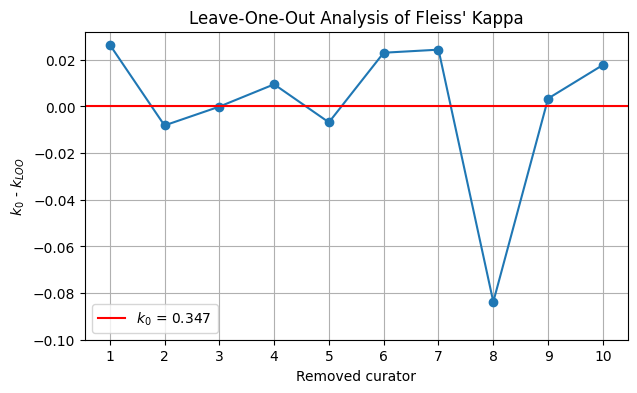

In [33]:
from sklearn.metrics import cohen_kappa_score
import seaborn as sns
import matplotlib.pyplot as plt

original_kappa = fleiss_kappa(overlap_evals,['C','I','U'])
n_raters = len(list(overlap_evals.values())[0])
print(f"Baseline Fleiss' Kappa: {original_kappa:.3f}")

# 1. Pairwise Agreement (Cohen's Kappa)
# df = pd.DataFrame(overlap_evals, columns=None, index=None).T
# pairwise_kappas = np.zeros((n_raters, n_raters))
# for i in range(n_raters):
#     for j in range(n_raters):
#         if i == j:
#             pairwise_kappas[i, j] = 1  # Self-agreement is always 1
#         else:
#             pairwise_kappas[i, j] = cohen_kappa_score(df.iloc[:, i], df.iloc[:, j])
# pairwise_kappas = pd.DataFrame(pairwise_kappas)

# plt.figure(figsize=(6, 5))
# sns.heatmap(pairwise_kappas, annot=True, cmap='coolwarm', center=0)
# plt.gca().xaxis.tick_top()
# plt.title('Pairwise Cohen\'s Kappa')
# plt.show()

# 2. Leave-One-Out Analysis
loo_kappas = []
for i in range(n_raters):
    evals = {rel:[rel_evals[j] for j in range(n_raters) if i != j] for rel,rel_evals in overlap_evals.items()}
    loo_kappas.append(fleiss_kappa(evals, ['C','I','U']))

loo_deltas = [original_kappa-k for k in loo_kappas]

plt.figure(figsize=(7, 4))
plt.plot(range(1,len(loo_deltas)+1), loo_deltas, marker='o')
plt.title('Leave-One-Out Analysis of Fleiss\' Kappa')
plt.axhline(y=0, color='r', linestyle='-', label=f'$k_{0}$ = {original_kappa:.3f}')
plt.xticks([i for i in range(1,11)])
plt.yticks([i*0.01 for i in range(-10,4,2)])
plt.xlabel('Removed curator')
plt.ylabel('$k_{0}$ - $k_{LOO}$')
plt.legend()
plt.grid()
plt.show()

In [34]:
# Compute precision, recall, f1
def confusion_matrix(preds, evals):
    tp, tn, fp, fn, unc = 0, 0, 0, 0, 0
    for i,eva in enumerate(evals):
        if eva == 'U': unc += 1
        elif eva == 'C' and preds[i] == 1: tp += 1
        elif eva == 'I' and preds[i] == 1: fp += 1
        elif eva == 'C' and preds[i] == 0: tn += 1
        elif eva == 'I' and preds[i] == 0: fn += 1
    return (tp, fp, tn, fn, unc)

def score(TP, FP, FN):
    prc = TP/(TP+FP)
    rcl = TP/(TP+FN)
    return prc, rcl, 2*(prc*rcl)/(prc+rcl) if prc+rcl != 0 else 0

def drop_raters(df:pd.DataFrame, raters:list):
	out_df = df.copy(deep=True)
	for rater in raters:
		out_df = out_df.drop(range(rater*20,rater*20+20))
	return out_df

RATER_DROP_THRESHOLD = 0.05
droped_raters = [loo_deltas.index(delta) for delta in loo_deltas if abs(delta) >= RATER_DROP_THRESHOLD]
# droped_raters = []
clean_val_dataset = drop_raters(val_dataset, droped_raters)
preds = clean_val_dataset['pred'].tolist()
evals = clean_val_dataset['eval'].tolist()

cm = confusion_matrix(preds,evals)
tp, fp, tn, fn, unc = cm
prc, rcl, f1 = score(tp,fp,fn)
filtered_evals = {rel:[rel_evals[i] for i in range(n_raters) if i not in droped_raters] for rel,rel_evals in overlap_evals.items()}
k = fleiss_kappa(filtered_evals, ['C','I','U'])
print(f"Number of validated relations: {sum(cm)}")
print(f"TP: {tp} | FP: {fp} | TN: {tn} | FN: {fn}")
print(f"Precision: {prc:.3f}")
print(f"Recall:    {rcl:.3f}")
print(f"F1:        {f1:.3f}")
print(f"Fleiss' K: {k:.3f}")
print(f"Number of Uncertains: {unc} ({unc/sum(cm)*100:.1f}%)")

Number of validated relations: 180
TP: 54 | FP: 17 | TN: 14 | FN: 57
Precision: 0.761
Recall:    0.486
F1:        0.593
Fleiss' K: 0.431
Number of Uncertains: 38 (21.1%)


### Create Train/Test Sets

In [29]:
RATER_DROP_THRESHOLD = 0.1
PATH = '../llms/data/'

In [30]:
# Create Train/Test Set
import os

def get_true_label(row):
	if row['eval'] == 'U': return 'U'
	if row['eval'] == 'C': return row['pred']
	# if pred == 1 and is Incorrect: return 0 and vice-versa
	if row['eval'] == 'I': return int(not bool(row['pred'])) 

droped_raters = [loo_deltas.index(delta) for delta in loo_deltas if delta <= RATER_DROP_THRESHOLD]
clean_val_dataset = drop_raters(val_dataset, droped_raters)

clean_val_dataset['true_label'] = clean_val_dataset.apply(get_true_label, axis=1)
clean_val_dataset.drop(["pred","eval"], axis=1, index=None, inplace=True)
pos = clean_val_dataset[clean_val_dataset['true_label'] == 1]
neg = clean_val_dataset[clean_val_dataset['true_label'] == 0]
unc = clean_val_dataset[clean_val_dataset['true_label'] == 'U']

train_p = 0.7
pos_size = round(len(pos)*train_p)
neg_size = round(len(neg)*train_p)
unc_size = round(len(unc)*train_p)

if not os.path.exists(PATH+'train.csv'):
	train = pd.concat([pos[:pos_size],neg[:pos_size]]).sort_values(by='ID')
	train.to_csv(PATH+'train.csv', sep='\t', index=None)
	
	test = pd.concat([pos[pos_size:],neg[pos_size:]]).sort_values(by='ID')
	test.to_csv(PATH+'test.csv', sep='\t', index=None)
	
	train_u = pd.concat([train,unc[:unc_size]]).sort_values(by='ID')
	train_u.to_csv(PATH+'train_u.csv', sep='\t', index=None)

	test_u = pd.concat([test,unc[unc_size:]]).sort_values(by='ID')
	test_u.to_csv(PATH+'test_u.csv', sep='\t', index=None)

else: # Add new rows to the test
	# get new rows that are not in the train set
	train_ids = list(pd.read_csv(PATH+'train_u.csv', sep='\t')['ID'])
	test_ids = list(pd.read_csv(PATH+'test_u.csv', sep='\t')['ID'])
	old_ids = train_ids+test_ids
	
	new_pos = pos[~pos['ID'].isin(old_ids)]
	new_neg = neg[~neg['ID'].isin(old_ids)]
	new_unc = unc[~unc['ID'].isin(old_ids)]
	
	# add new rows to test and test_u
	if not new_pos.empty or not new_neg.empty:
		test = pd.read_csv(PATH+'test.csv', sep='\t')
		test = pd.concat([test,new_pos,new_neg]).sort_values(by='ID')
		test.to_csv(PATH+'test.csv', sep='\t', index=None)

		test_u = pd.read_csv(PATH+'test_u.csv', sep='\t')
		test_u = pd.concat([test_u,new_pos,new_neg]).sort_values(by='ID')
		test_u.to_csv(PATH+'test_u.csv', sep='\t', index=None)

	if not new_unc.empty:
		test_u = pd.read_csv(PATH+'test_u.csv', sep='\t')
		test_u = pd.concat([test_u,new_unc]).sort_values(by='ID')
		test_u.to_csv(PATH+'test_u.csv', sep='\t', index=None)